# Mounting Google Drive

In [0]:
##### before running it, make sure you don't have lots of big files in your google drive
##### otherwise it's going to take too long to finish running it before giving the TIMEOUT error
##### also save the train_controls, train_patients, val_controls, val_patients to your drive and
##### create a "train" folder with train_controls, train_patients in it, and 
##### a "val" folder with val_controls, val_patients in it.
##### change the train_dir and val_dir in the next cell to the dir of your train and val folder
##### e.g. my train and val folder are saved in the "deep learning" dir

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Loading Train, Val, and Test Data Using Keras ImageDataGenerator

In [0]:
#Kavi's and Chelsea's Dir
train_dir = "/gdrive/My Drive/kaggle_dataset/train/"
val_dir = "/gdrive/My Drive/kaggle_dataset/val/"
test_dir = "/gdrive/My Drive/kaggle_dataset/test/"

# Daniel's dir:
# train_dir = "/gdrive/My Drive/deep learning/Project/trainProbMaps/"
# val_dir = "/gdrive/My Drive/deep learning/Project/valProbMaps/"
# test_dir = "/gdrive/My Drive/deep learning/Project/testProbMaps/"

img_width = 224
img_height = 224
batch_size = 1
channels = 3
epochs = 50
nb_train_samples = 8000
nb_valid_samples = 32
nb_test_samples = 968

n_classes = 4

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)             
valid_datagen = ImageDataGenerator(rescale=1./255)    
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)   

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True) #weight toward one class or another

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Using TensorFlow backend.


Found 8000 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


# Building the Model Architecture (Pre-trained Keras VGG16 Extracting Features from OCT Dataset) & Training the Model

In [0]:
import numpy as np 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Softmax, Flatten, Dense, BatchNormalization 
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from keras.models import Sequential

from PIL import Image

Image.MAX_IMAGE_PIXELS = None

from keras import layers

from keras.callbacks import TensorBoard

#from keras.layers import Input, Dense
from keras import layers
from keras.applications import resnet50
from keras import optimizers
from keras.applications import VGG16

#pretrained VGG16 on imagenet, starting to replicate Hassan's work
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_height, img_width, channels))

#conv_base.summary()

#Extracting features from OCT data using pretrained VGG
def extract_features(dataset_type, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    if dataset_type == "train":
        for inputs_batch, labels_batch in train_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break   
    elif dataset_type == "valid":
        for inputs_batch, labels_batch in valid_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break
    else:
        for inputs_batch, labels_batch in test_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break
    return features, labels

train_features, train_labels = extract_features("train", nb_train_samples)
valid_features, valid_labels = extract_features("valid", nb_valid_samples)
test_features, test_labels = extract_features("test", nb_test_samples)


print(train_features.shape, train_labels.shape)
print(valid_features.shape, valid_labels.shape)
print(test_features.shape, test_labels.shape)

58892288/58889256 [==============================] - 2s 0us/step
(8000, 7, 7, 512) (8000,)
(32, 7, 7, 512) (32,)
(968, 7, 7, 512) (968,)


# Classifier Layer: Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0, bootstrap=True)
clf.fit(np.reshape(train_features, (nb_train_samples, 7*7*512)), train_labels)

valid_prediction = clf.predict(np.reshape(valid_features, (nb_valid_samples, 7*7*512)))
# print("validation accuracy:", sum([prediction[i] == valid_labels[i] for i in range(len(valid_labels))])/len(valid_labels))
#print(prediction)
#print(valid_labels)

test_prediction = clf.predict(np.reshape(test_features, (nb_test_samples, 7*7*512)))
# print("test accuracy:", sum([prediction[i] == test_labels[i] for i in range(len(test_labels))])/len(test_labels))
# print(test_prediction)
# print(test_labels)


In [0]:
valid_score = clf.score(np.reshape(valid_features, (nb_valid_samples, 7*7*512)), valid_labels)
test_score = clf.score(np.reshape(test_features, (nb_test_samples, 7*7*512)), test_labels)

print("valid accuracy:", valid_score)
print("test accuracy:", test_score)

valid accuracy: 0.84375
test accuracy: 0.8884297520661157


In [0]:
from sklearn.metrics import roc_curve, auc

# print(valid_labels)
# print(valid_prediction)

# Validation
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_labels, valid_prediction, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("valid AUC for class", i, roc_auc[i])
    
    
print("\n")
    
# Test
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_prediction, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("test AUC for class", i, roc_auc[i])

# fpr, tpr, thresholds = metrics.roc_curve(valid_labels, valid_prediction, pos_label=1)
# print("valid AUC:", metrics.auc(fpr, tpr))
# fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_prediction, pos_label=1)
# print("test AUC:", metrics.auc(fpr, tpr))

[2. 3. 0. 3. 0. 3. 2. 0. 1. 1. 0. 0. 1. 0. 2. 2. 1. 1. 3. 3. 0. 3. 2. 3.
 2. 1. 0. 3. 2. 2. 1. 1.]
[2. 3. 2. 3. 0. 3. 0. 0. 1. 1. 0. 0. 1. 0. 2. 2. 3. 1. 3. 3. 0. 3. 0. 3.
 2. 1. 0. 3. 2. 2. 1. 2.]
valid AUC for class 0 0.09635416666666669
valid AUC for class 1 0.4505208333333333
valid AUC for class 2 0.47395833333333337
valid AUC for class 3 0.9791666666666666


test AUC for class 0 0.056183548482571774
test AUC for class 1 0.42807299137126337
test AUC for class 2 0.537582815381463
test AUC for class 3 0.9781606447647018


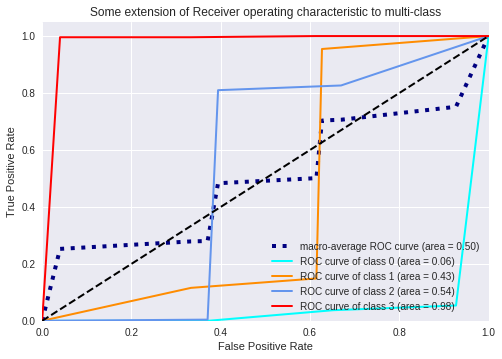

In [0]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

lw = 2

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Not running for this trial
## Testing

In [0]:
#print(train_generator.filenames)
#print(validation_generator.filenames)

nb_test_samples = 102

result = model.evaluate_generator(test_generator, steps=nb_test_samples / batch_size)
print(result)

predictions = model.predict_generator(test_generator, steps=nb_test_samples / batch_size)
print(predictions)
print(len(predictions))
img_path = "/gdrive/My Drive/validation/val_patients/patient13.png"

from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                               


print(img_tensor.shape)
#validation_generator.classes

# Visualizing

In [0]:
import matplotlib.pyplot as plt

#plt.imshow(img_tensor[0])
#plt.show()

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt
plt.figure()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

# Visualizing attention map

In [0]:
# !pip install keras-vis
!pip install git+https://github.com/raghakot/keras-vis.git

from keras.applications import ResNet50
from vis.utils import utils
from keras import activations

# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

In [0]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# img1 = utils.load_img('/gdrive/My Drive/deep_learning/val/val_controls/_ERGO-0449_OS_2014_triton_wf_report.png', 
#                       target_size=(img_width / 5, img_height / 5))
# img2 = utils.load_img('/gdrive/My Drive/deep_learning/val/val_controls/_ERGO-0450_OD_2014_triton_wf_report.png', 
#                       target_size=(img_width / 5, img_height / 5))

img1 = utils.load_img('/gdrive/My Drive/deep_learning/new_dataset/test/controls/View2098.png', 
                      target_size=(img_width, img_height))
img2 = utils.load_img('/gdrive/My Drive/deep_learning/new_dataset/train/patients/194.png', 
                      target_size=(img_width, img_height))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [0]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_cam


# import numpy as np
import matplotlib.cm as cm
# from vis.visualization import visualize_cam


penultimate_layer = utils.find_layer_idx(model, 'conv2d_15')
layer_idx = utils.find_layer_idx(model, 'dense_9')

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(jet_heatmap)
        ax[i + 2].imshow(img)
#         ax[i].imshow(jet_heatmap)
#         print(jet_heatmap.shape)
#         print(img.shape)
#         ax[i].imshow(overlay(jet_heatmap, img))
